In [2]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("Running on CPU")


PyTorch version: 2.6.0+cu124
CUDA available: True
GPU name: NVIDIA A100-SXM4-40GB


In [3]:
!pip install torch torchvision scikit-learn numpy pillow

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install torch torchvision torchaudio


In [5]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from collections import Counter
from PIL import Image
import torchvision.models as models

In [6]:
!unzip -q "/content/drive/MyDrive/plant_disease_dataset.zip" -d "/content/plant_disease_dataset"

replace /content/plant_disease_dataset/plant_disease_dataset/Test/Healthy/8ddaa5a5caa5caa8.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [7]:
import os

for root, dirs, files in os.walk("plant_disease_dataset"):
    print("Root:", root)
    print("Subfolders:", dirs)
    print("Files:", files)
    break


Root: plant_disease_dataset
Subfolders: ['plant_disease_dataset']
Files: []


In [8]:
dataset_path = "/content/plant_disease_dataset/plant_disease_dataset"
train_path = os.path.join(dataset_path, "Train")
val_path = os.path.join(dataset_path, "Validation")
test_path = os.path.join(dataset_path, "Test")

print("Train Dataset Path:", train_path)
print("Validation Dataset Path:", val_path)
print("Test Dataset Path:", test_path)


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Train Dataset Path: /content/plant_disease_dataset/plant_disease_dataset/Train
Validation Dataset Path: /content/plant_disease_dataset/plant_disease_dataset/Validation
Test Dataset Path: /content/plant_disease_dataset/plant_disease_dataset/Test


In [9]:
def list_subfolders(path):
    return [f.name for f in os.scandir(path) if f.is_dir()]

print("Train Subfolders:", list_subfolders(train_path))
print("Validation Subfolders:", list_subfolders(val_path))
print("Test Subfolders:", list_subfolders(test_path))

Train Subfolders: ['Healthy', 'Powdery', 'Rust']
Validation Subfolders: ['Healthy', 'Powdery', 'Rust']
Test Subfolders: ['Healthy', 'Powdery', 'Rust']


In [10]:
# Load dataset using ImageFolder
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

print(f" Dataset loaded")


 Dataset loaded


In [11]:
print(f"Total images in dataset: {len(dataset)}")
print(f"Number of classes: {len(dataset.classes)}\n")

print("Class names:")
for idx, class_name in enumerate(dataset.classes):
    print(f"{idx}: {class_name}")


Total images in dataset: 1532
Number of classes: 3

Class names:
0: Test
1: Train
2: Validation


In [12]:
!pip install matplotlib

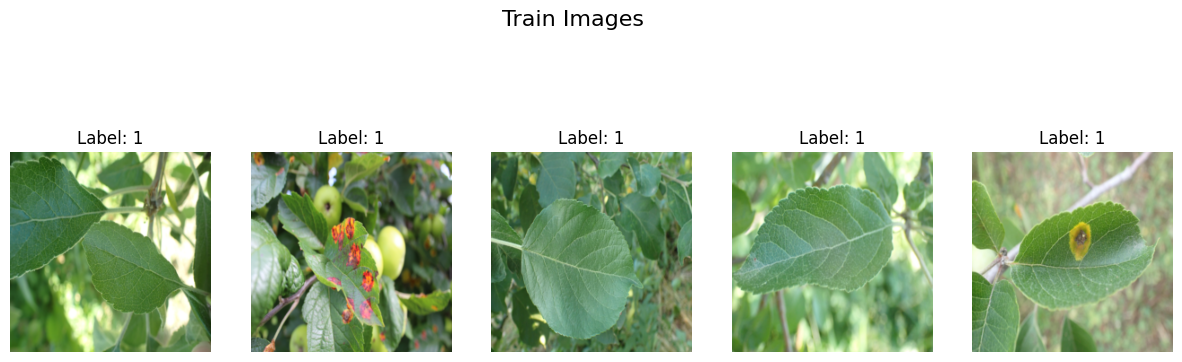

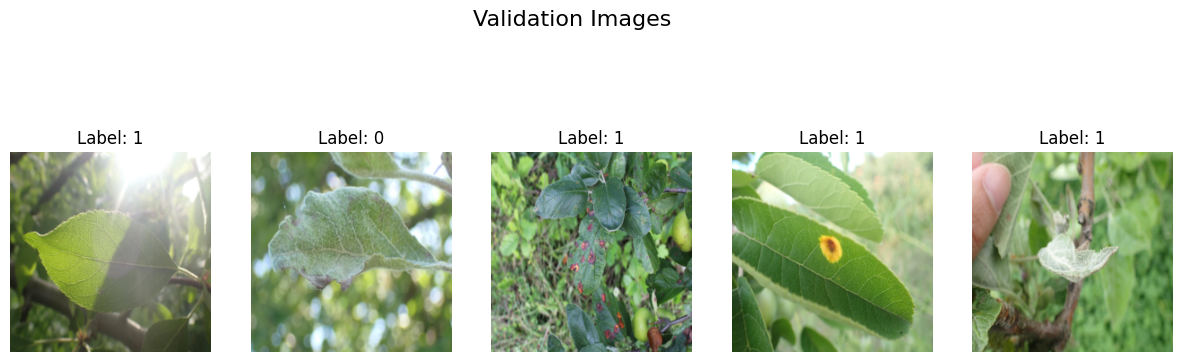

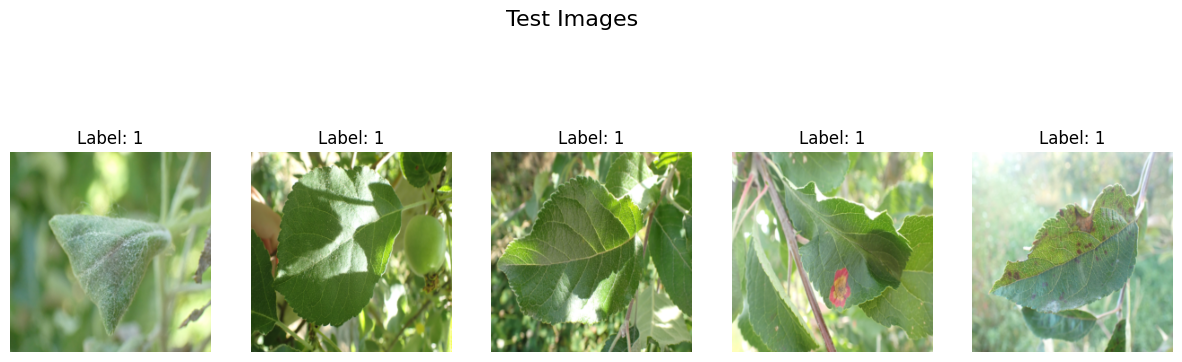

In [13]:
import matplotlib.pyplot as plt

def show_images_from_loader(loader, title, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)

    data_iter = iter(loader)
    images, labels = next(data_iter)

    for i in range(num_images):
        image = images[i].permute(1, 2, 0).numpy()
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {labels[i].item()}")

    plt.show()

show_images_from_loader(train_loader, "Train Images")
show_images_from_loader(val_loader, "Validation Images")
show_images_from_loader(test_loader, "Test Images")


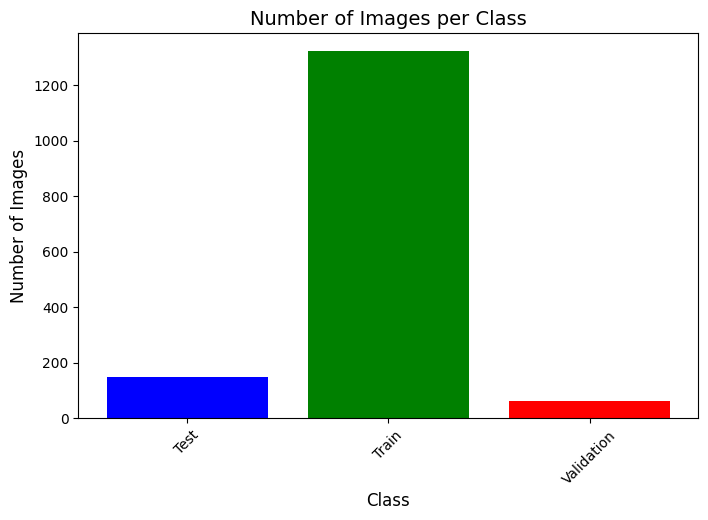

In [14]:
class_counts = Counter(label for _, label in dataset.samples)
class_names = [dataset.classes[label] for label in class_counts.keys()]

plt.figure(figsize=(8, 5))
plt.bar(class_names, class_counts.values(), color=['blue', 'green', 'red'])
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Number of Images per Class", fontsize=14)
plt.xticks(rotation=45)
plt.show()



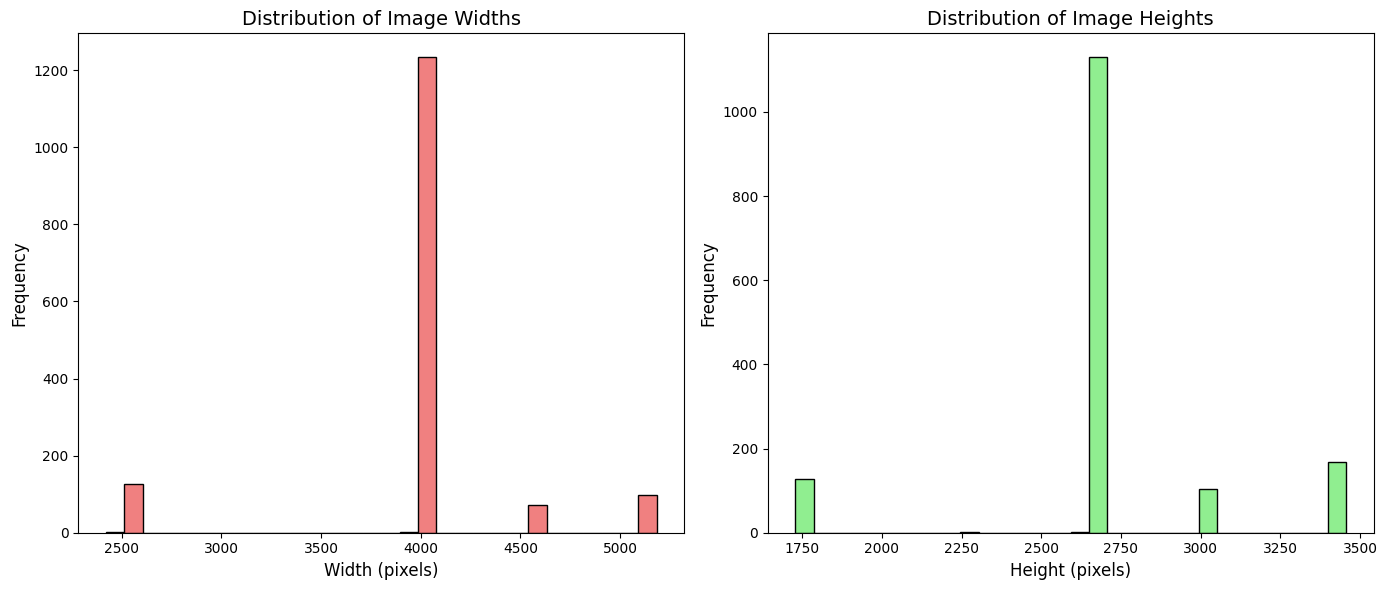

In [15]:
image_sizes = [Image.open(path).size for path, _ in dataset.samples]

widths, heights = zip(*image_sizes)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='lightcoral', edgecolor='black')
plt.title("Distribution of Image Widths", fontsize=14)
plt.xlabel("Width (pixels)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='lightgreen', edgecolor='black')
plt.title("Distribution of Image Heights", fontsize=14)
plt.xlabel("Height (pixels)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.tight_layout()
plt.show()

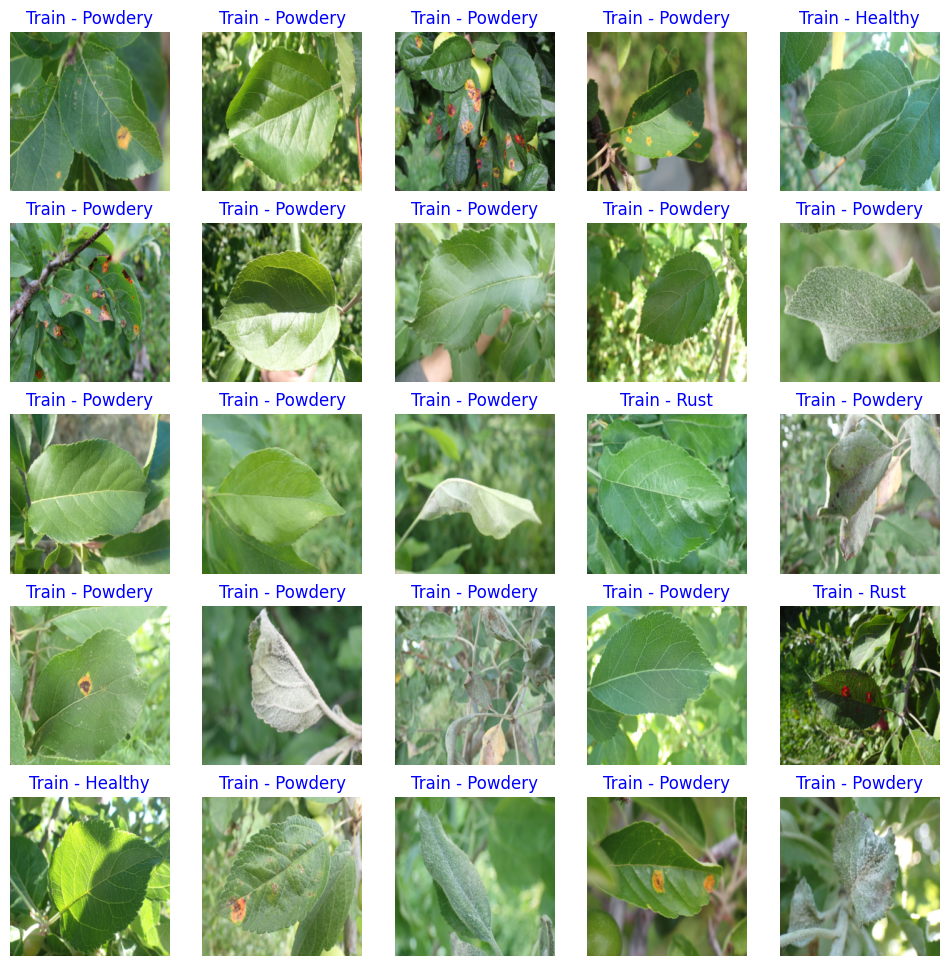

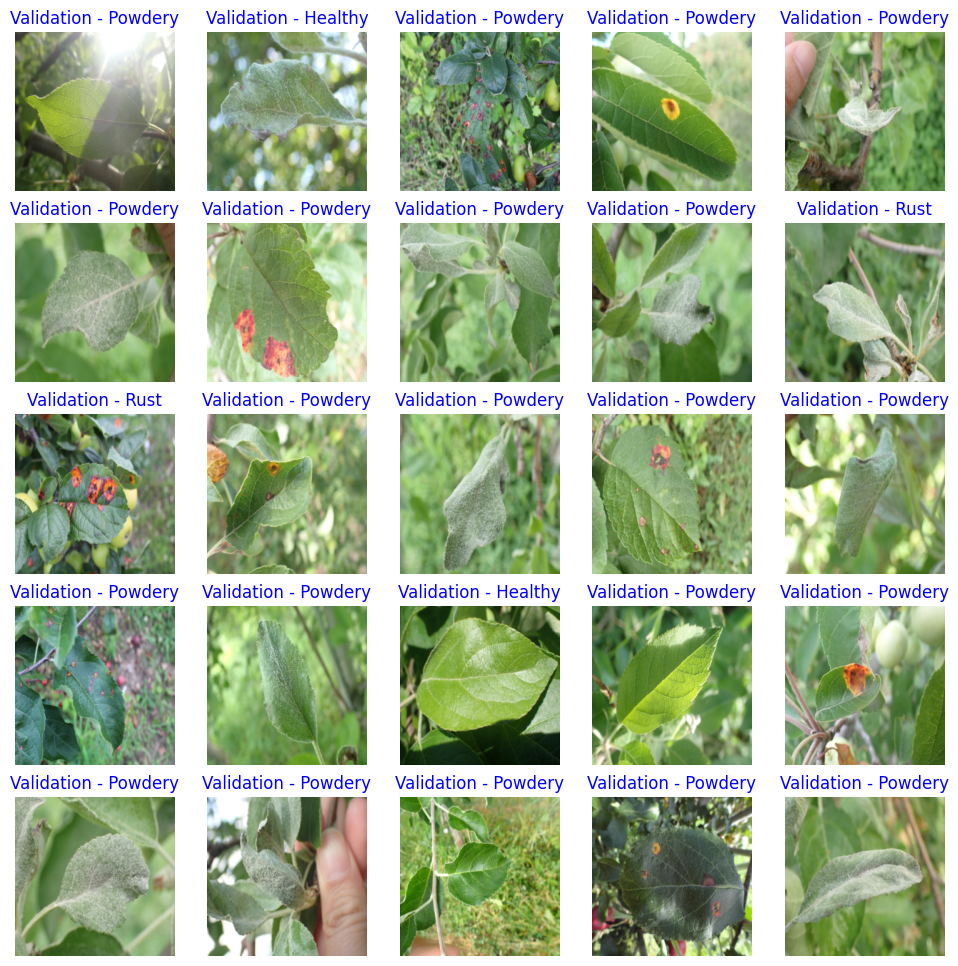

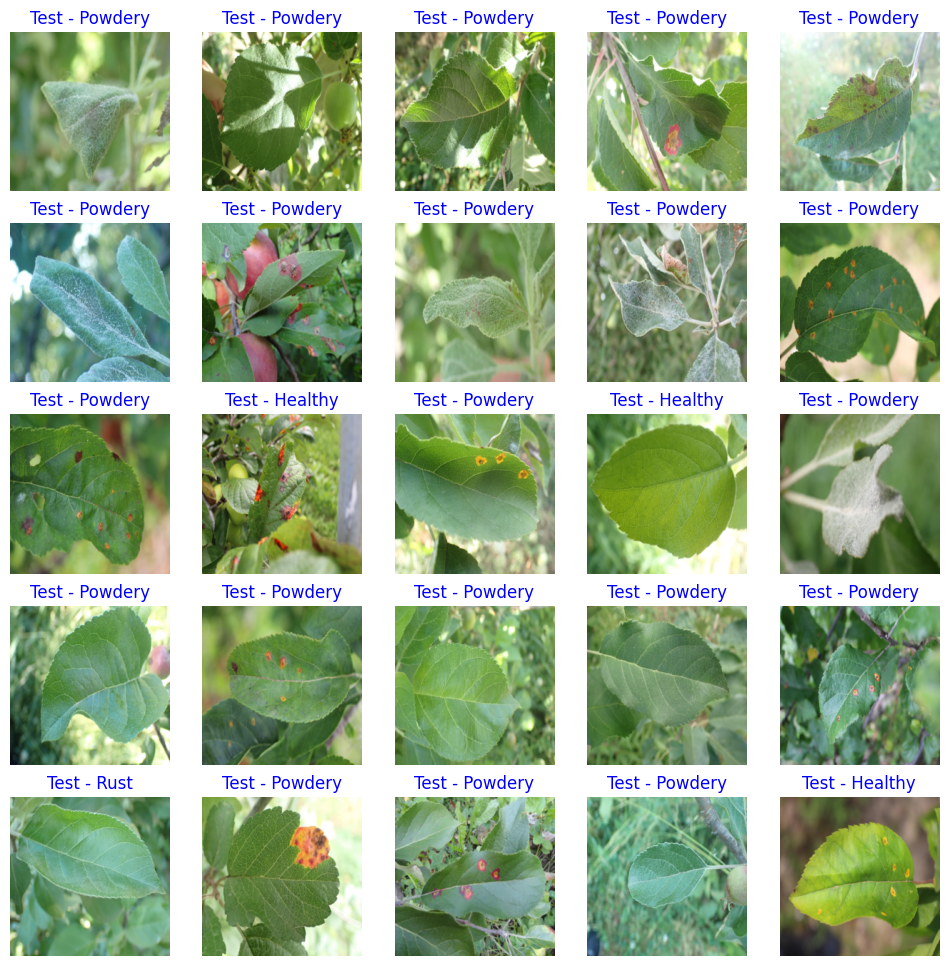

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

def show_image_samples(loader, dataset_type, class_names, num_images=25):

    images, labels = next(iter(loader))
    images = images.numpy().transpose((0, 2, 3, 1))

    num_images = min(num_images, len(images))
    plt.figure(figsize=(12, 12))

    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(np.clip(images[i], 0, 1))
        class_name = class_names[labels[i].item()]
        plt.title(f"{dataset_type} - {class_name}", color='blue', fontsize=12)
        plt.axis('off')

    plt.show()

class_names = ['Healthy', 'Powdery', 'Rust']

# Example usage:
show_image_samples(train_loader, "Train", class_names)
show_image_samples(val_loader, "Validation", class_names)
show_image_samples(test_loader, "Test", class_names)


CNN Model

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os



In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_path = "/content/plant_disease_dataset/plant_disease_dataset/Train"
val_path = "/content/plant_disease_dataset/plant_disease_dataset/Validation"
test_path = "/content/plant_disease_dataset/plant_disease_dataset/Test"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_path, transform=transform)
val_dataset = datasets.ImageFolder(val_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)



In [33]:
class_names = list(train_dataset.class_to_idx.keys())

class CNNModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 112 * 112, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class EarlyStopping:
    def __init__(self, patience=3, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_accuracy):
        if self.best_score is None or val_accuracy > self.best_score + self.delta:
            self.best_score = val_accuracy
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total


def evaluate_full(model, loader, class_names):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = sum(p == t for p, t in zip(y_pred, y_true)) / len(y_true)
    print(f"\nTest Accuracy: {acc:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap="Blues", values_format="d")
    plt.title("CNN - Confusion Matrix")
    plt.show()

    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))



In [34]:

def plot_training(train_losses, train_accuracies, model_name="CNN"):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o')
    plt.title(f"{model_name} - Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, marker='o', color='green')
    plt.title(f"{model_name} - Training Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)

    plt.tight_layout()
    plt.show()






 Starting Training...
Epoch [1/20] | Loss: 4.2740 | Train Acc: 0.6573 | Val Acc: 0.7333
 Best model saved!
Epoch [2/20] | Loss: 0.4295 | Train Acc: 0.8578 | Val Acc: 0.7333
Epoch [3/20] | Loss: 0.2423 | Train Acc: 0.8964 | Val Acc: 0.8000
 Best model saved!
Epoch [4/20] | Loss: 0.1095 | Train Acc: 0.9697 | Val Acc: 0.7500
Epoch [5/20] | Loss: 0.0543 | Train Acc: 0.9939 | Val Acc: 0.7833
Epoch [6/20] | Loss: 0.0278 | Train Acc: 0.9977 | Val Acc: 0.7833
 Early stopping triggered.


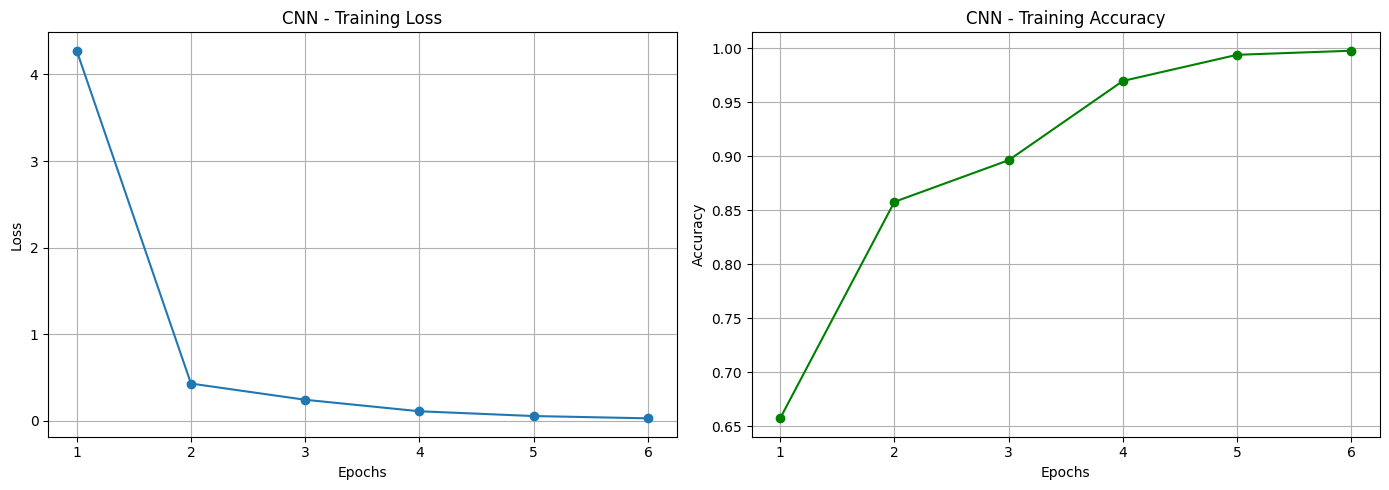


Test Accuracy: 0.7267


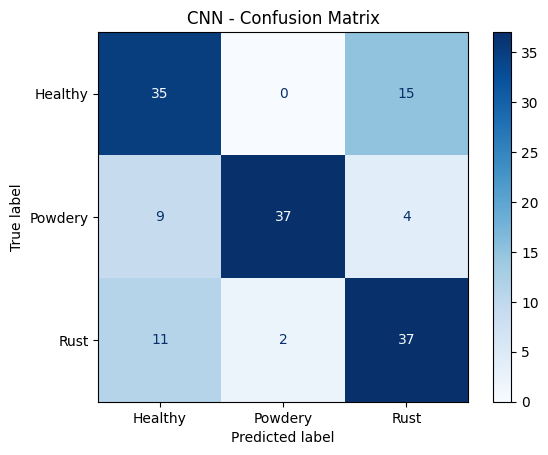


 Classification Report:
              precision    recall  f1-score   support

     Healthy       0.64      0.70      0.67        50
     Powdery       0.95      0.74      0.83        50
        Rust       0.66      0.74      0.70        50

    accuracy                           0.73       150
   macro avg       0.75      0.73      0.73       150
weighted avg       0.75      0.73      0.73       150



In [35]:
def train_model(model, train_loader, val_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
    early_stopping = EarlyStopping(patience=3)

    best_accuracy = 0.0
    train_losses, train_accuracies = [], []

    print("\n Starting Training...")
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        train_acc = correct / total
        val_acc = evaluate_model(model, val_loader)

        scheduler.step(avg_loss)
        train_losses.append(avg_loss)
        train_accuracies.append(train_acc)

        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            torch.save(model.state_dict(), "BestModel_CNN.pth")
            print(" Best model saved!")

        early_stopping(val_acc)
        if early_stopping.early_stop:
            print(" Early stopping triggered.")
            break

    return train_losses, train_accuracies

model = CNNModel(num_classes=3).to(device)
train_losses, train_accuracies = train_model(model, train_loader, val_loader, epochs=20)
plot_training(train_losses, train_accuracies)
model.load_state_dict(torch.load("BestModel_CNN.pth"))
evaluate_full(model, test_loader, class_names=class_names)

In [17]:
def get_features(loader):
    features, labels = [], []
    for images, label in loader:
        images = images.view(images.size(0), -1).numpy()
        features.extend(images)
        labels.extend(label.numpy())
    return features, labels

# Training SVM Model
svm_model = SVC(kernel='linear')
train_features, train_labels = get_features(train_loader)
svm_model.fit(train_features, train_labels)
print("SVM model training completed.")

SVM model training completed.


In [18]:
# Evaluating SVM
val_features, val_labels = get_features(val_loader)
svm_predictions = svm_model.predict(val_features)
svm_accuracy = accuracy_score(val_labels, svm_predictions)
print(f"SVM Validation Accuracy: {svm_accuracy:.4f}")

test_features, test_labels = get_features(test_loader)
test_predictions = svm_model.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"SVM Test Accuracy: {test_accuracy:.4f}")



SVM Validation Accuracy: 0.7712
SVM Test Accuracy: 0.7338


In [19]:
# Training Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(train_features, train_labels)
print("Random Forest model training completed.")

Random Forest model training completed.


In [20]:
# Evaluating Random Forest
rf_val_predictions = rf_model.predict(val_features)
rf_val_accuracy = accuracy_score(val_labels, rf_val_predictions)
print(f"Random Forest Validation Accuracy: {rf_val_accuracy:.4f}")

rf_test_predictions = rf_model.predict(test_features)
rf_test_accuracy = accuracy_score(test_labels, rf_test_predictions)
print(f"Random Forest Test Accuracy: {rf_test_accuracy:.4f}")

Random Forest Validation Accuracy: 0.8497
Random Forest Test Accuracy: 0.8052


ResNet18

In [24]:
class_names = list(train_dataset.class_to_idx.keys())

class EarlyStopping:
    def __init__(self, patience=3, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_accuracy):
        if self.best_score is None or val_accuracy > self.best_score + self.delta:
            self.best_score = val_accuracy
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


def modify_model(base_model, model_name, num_classes=3):
    if model_name == "ResNet18":
        base_model.fc = nn.Linear(base_model.fc.in_features, num_classes)
    elif model_name == "VGG16":
        base_model.classifier[6] = nn.Linear(base_model.classifier[6].in_features, num_classes)
    elif model_name == "EfficientNet":
        base_model.classifier[1] = nn.Linear(base_model.classifier[1].in_features, num_classes)
    elif model_name == "ViT":
        base_model.heads.head = nn.Linear(base_model.heads.head.in_features, num_classes)
    return base_model




In [30]:
def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


In [31]:
def evaluate_full(model, loader, class_names, model_name):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = sum(p == t for p, t in zip(y_pred, y_true)) / len(y_true)
    print(f"\n Test Accuracy ({model_name}): {acc:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap="Blues", values_format="d")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))


def plot_training(train_losses, train_accuracies, model_name):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o')
    plt.title(f"{model_name} - Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, marker='o', color='green')
    plt.title(f"{model_name} - Training Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.tight_layout()
    plt.show()





 Training ResNet18...
Epoch [1/10] | Loss: 0.1766 | Train Acc: 0.9372 | Val Acc: 0.9500
 Best model saved!
Epoch [2/10] | Loss: 0.0592 | Train Acc: 0.9781 | Val Acc: 1.0000
 Best model saved!
Epoch [3/10] | Loss: 0.0361 | Train Acc: 0.9894 | Val Acc: 1.0000
Epoch [4/10] | Loss: 0.0546 | Train Acc: 0.9803 | Val Acc: 0.7333
Epoch [5/10] | Loss: 0.0271 | Train Acc: 0.9924 | Val Acc: 1.0000
 Early stopping triggered.


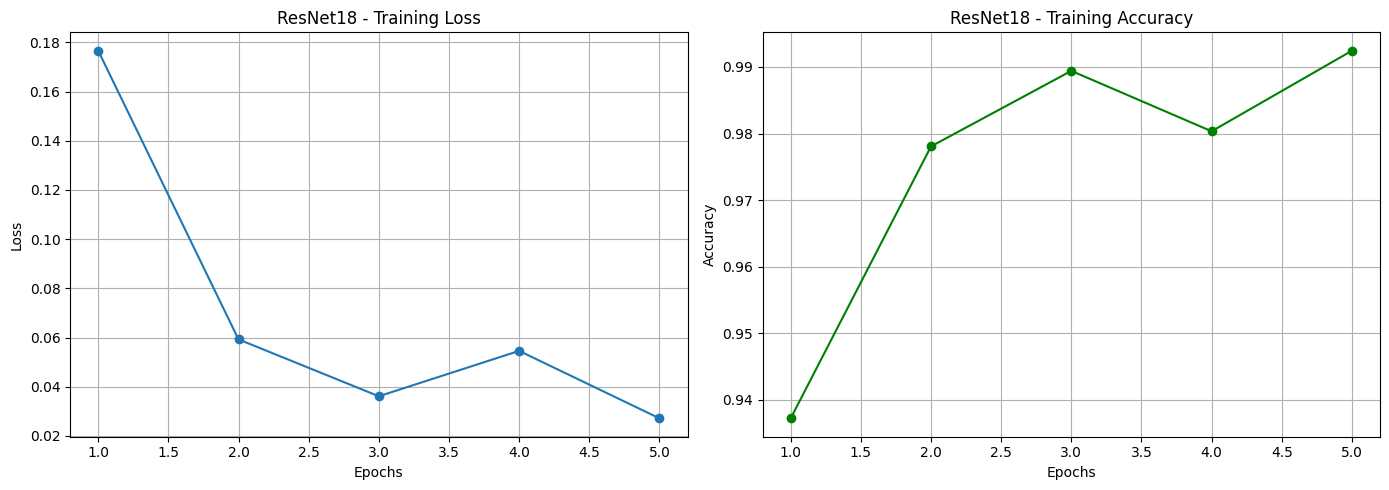


 Test Accuracy (ResNet18): 0.9600


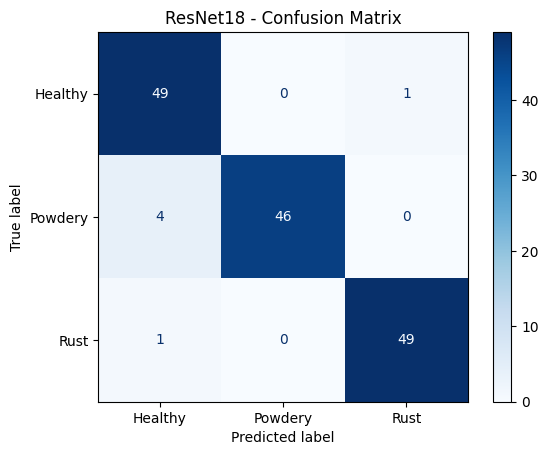


 Classification Report:
              precision    recall  f1-score   support

     Healthy       0.91      0.98      0.94        50
     Powdery       1.00      0.92      0.96        50
        Rust       0.98      0.98      0.98        50

    accuracy                           0.96       150
   macro avg       0.96      0.96      0.96       150
weighted avg       0.96      0.96      0.96       150



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 232MB/s]



 Training VGG16...
Epoch [1/10] | Loss: 1.2834 | Train Acc: 0.3510 | Val Acc: 0.3333
 Best model saved!
Epoch [2/10] | Loss: 1.1696 | Train Acc: 0.3638 | Val Acc: 0.4333
 Best model saved!
Epoch [3/10] | Loss: 1.0802 | Train Acc: 0.3979 | Val Acc: 0.4333
Epoch [4/10] | Loss: 1.1375 | Train Acc: 0.3835 | Val Acc: 0.3000
Epoch [5/10] | Loss: 0.8328 | Train Acc: 0.5575 | Val Acc: 0.6833
 Best model saved!
Epoch [6/10] | Loss: 0.6033 | Train Acc: 0.6293 | Val Acc: 0.6500
Epoch [7/10] | Loss: 0.5467 | Train Acc: 0.6536 | Val Acc: 0.6667
Epoch [8/10] | Loss: 0.5638 | Train Acc: 0.6755 | Val Acc: 0.6667
 Early stopping triggered.


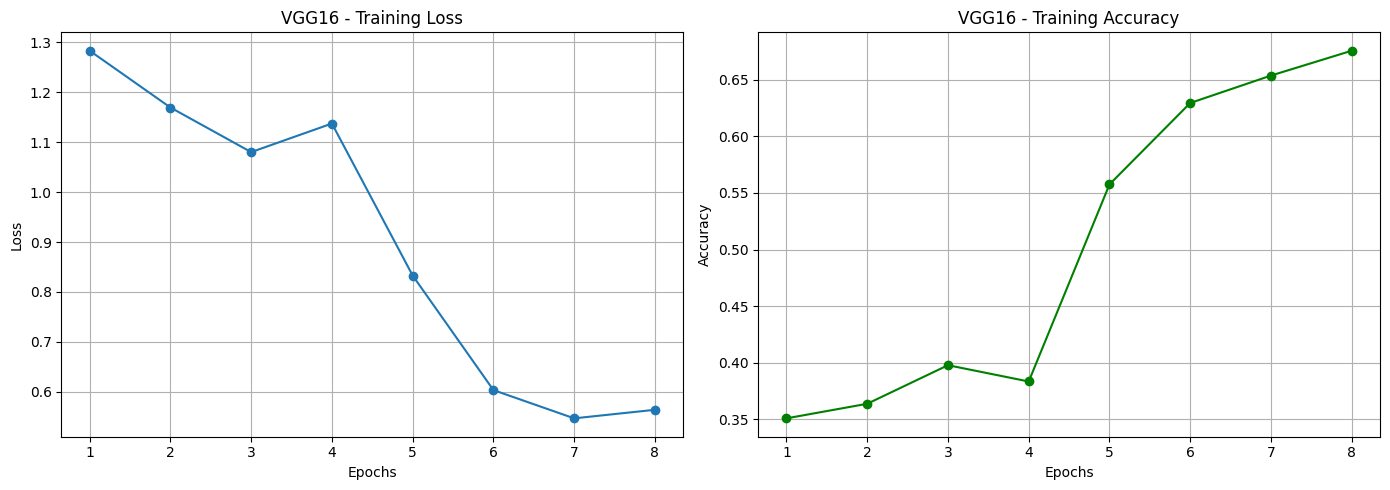


 Test Accuracy (VGG16): 0.6533


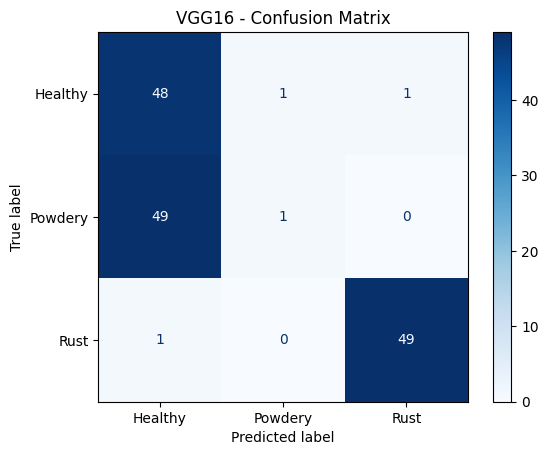


 Classification Report:
              precision    recall  f1-score   support

     Healthy       0.49      0.96      0.65        50
     Powdery       0.50      0.02      0.04        50
        Rust       0.98      0.98      0.98        50

    accuracy                           0.65       150
   macro avg       0.66      0.65      0.56       150
weighted avg       0.66      0.65      0.56       150



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 131MB/s] 



 Training EfficientNet...
Epoch [1/10] | Loss: 0.1614 | Train Acc: 0.9440 | Val Acc: 1.0000
 Best model saved!
Epoch [2/10] | Loss: 0.0557 | Train Acc: 0.9796 | Val Acc: 1.0000
Epoch [3/10] | Loss: 0.0916 | Train Acc: 0.9803 | Val Acc: 0.9667
Epoch [4/10] | Loss: 0.0325 | Train Acc: 0.9902 | Val Acc: 0.9833
 Early stopping triggered.


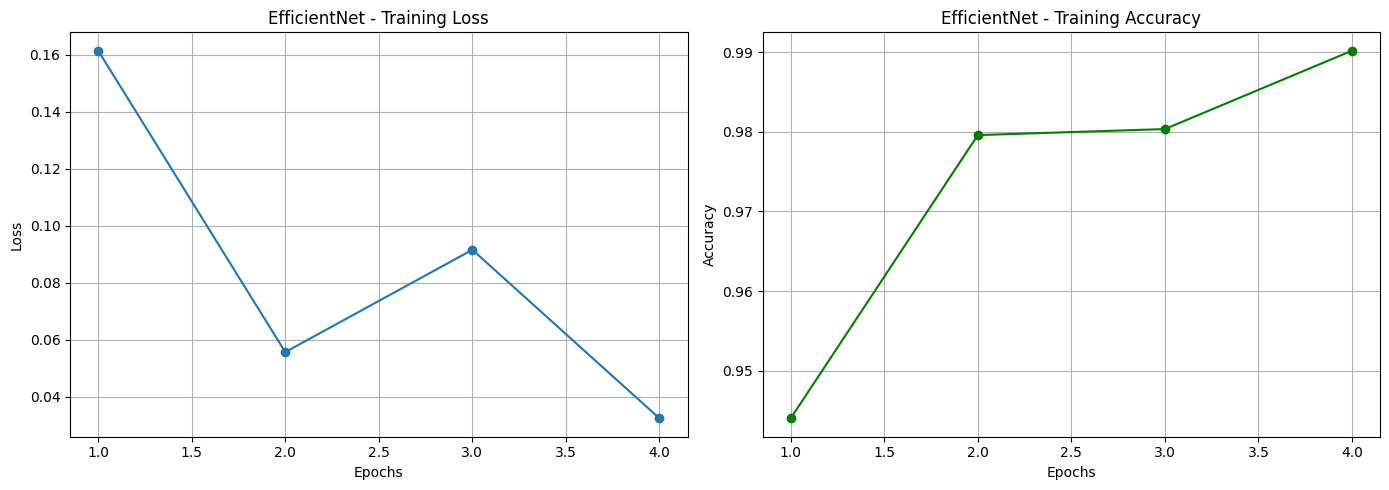


 Test Accuracy (EfficientNet): 0.9733


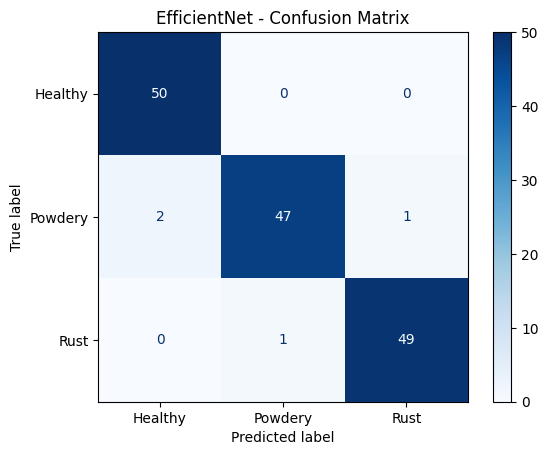


 Classification Report:
              precision    recall  f1-score   support

     Healthy       0.96      1.00      0.98        50
     Powdery       0.98      0.94      0.96        50
        Rust       0.98      0.98      0.98        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 222MB/s]



 Training ViT...
Epoch [1/10] | Loss: 1.2733 | Train Acc: 0.3616 | Val Acc: 0.3333
 Best model saved!
Epoch [2/10] | Loss: 0.9786 | Train Acc: 0.4970 | Val Acc: 0.5000
 Best model saved!
Epoch [3/10] | Loss: 0.9365 | Train Acc: 0.5431 | Val Acc: 0.3833
Epoch [4/10] | Loss: 0.9731 | Train Acc: 0.5030 | Val Acc: 0.3333
Epoch [5/10] | Loss: 1.0558 | Train Acc: 0.4470 | Val Acc: 0.4167
 Early stopping triggered.


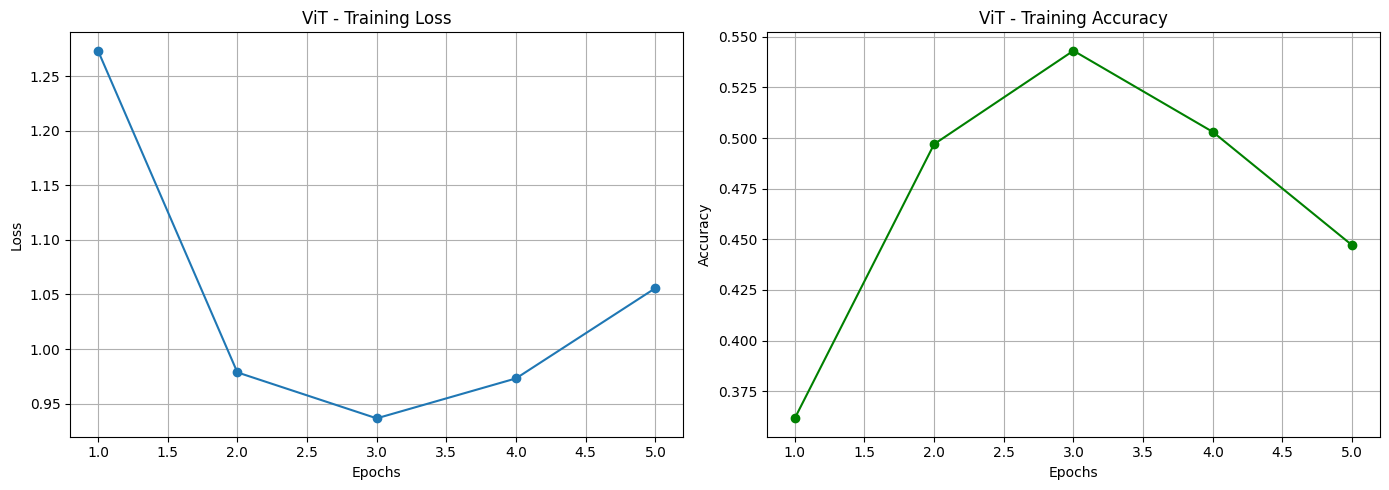


 Test Accuracy (ViT): 0.5600


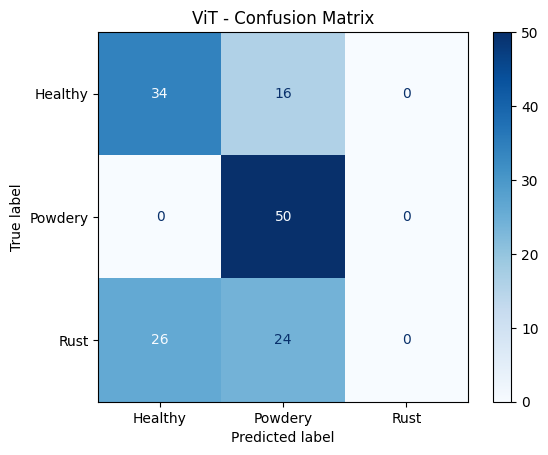


 Classification Report:
              precision    recall  f1-score   support

     Healthy       0.57      0.68      0.62        50
     Powdery       0.56      1.00      0.71        50
        Rust       0.00      0.00      0.00        50

    accuracy                           0.56       150
   macro avg       0.37      0.56      0.44       150
weighted avg       0.37      0.56      0.44       150



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [32]:
def train_model(model, model_name):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
    early_stopping = EarlyStopping(patience=3)

    best_accuracy = 0.0
    train_losses, train_accuracies = [], []

    print(f"\n Training {model_name}...")
    for epoch in range(10):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        train_acc = correct / total
        val_acc = evaluate_model(model, val_loader)

        scheduler.step(avg_loss)
        train_losses.append(avg_loss)
        train_accuracies.append(train_acc)

        print(f"Epoch [{epoch+1}/10] | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            torch.save(model.state_dict(), f"BestModel_{model_name}.pth")
            print(" Best model saved!")

        early_stopping(val_acc)
        if early_stopping.early_stop:
            print(" Early stopping triggered.")
            break

    plot_training(train_losses, train_accuracies, model_name)
    model.load_state_dict(torch.load(f"BestModel_{model_name}.pth"))
    evaluate_full(model, test_loader, class_names, model_name)

model_classes = {
    "ResNet18": models.resnet18,
    "VGG16": models.vgg16,
    "EfficientNet": models.efficientnet_b0,
    "ViT": models.vit_b_16
}

for model_name, model_func in model_classes.items():
    base_model = model_func(pretrained=True)
    model = modify_model(base_model, model_name, num_classes=3)
    train_model(model, model_name)


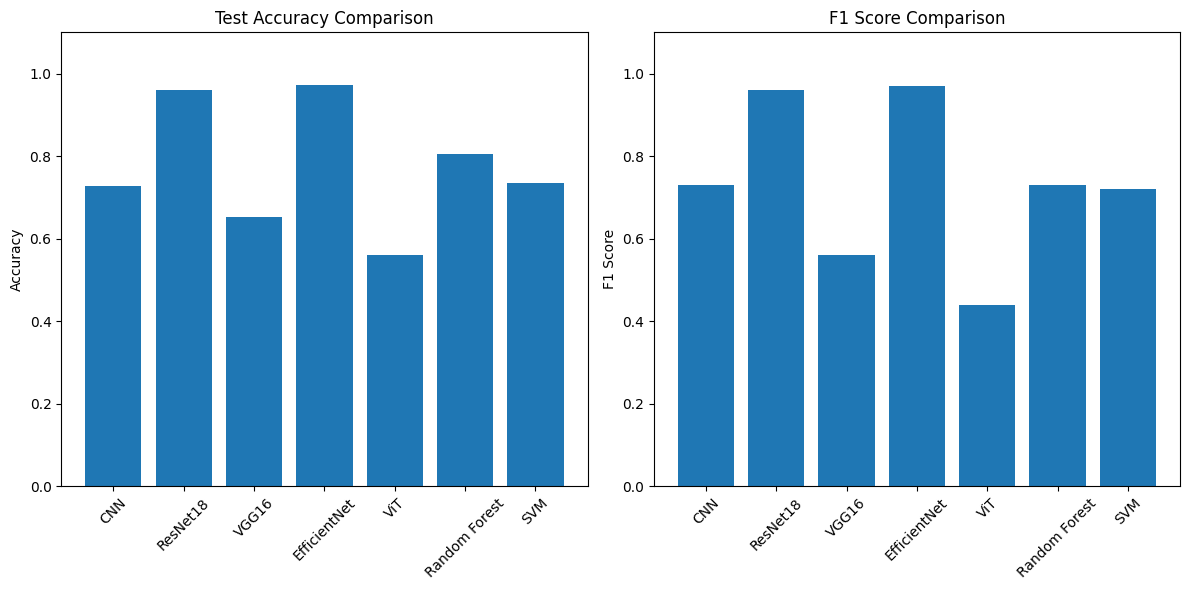

In [47]:
import matplotlib.pyplot as plt
import numpy as np

models = ["CNN", "ResNet18", "VGG16", "EfficientNet", "ViT", "Random Forest", "SVM"]

accuracies = [0.7267, 0.9600, 0.6533, 0.9733, 0.5600, 0.8052, 0.7338]

f1_scores = [0.73, 0.96, 0.56, 0.97, 0.44, 0.73, 0.72]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(models, accuracies)
plt.title("Test Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1.1)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(models, f1_scores)
plt.title("F1 Score Comparison")
plt.ylabel("F1 Score")
plt.ylim(0, 1.1)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


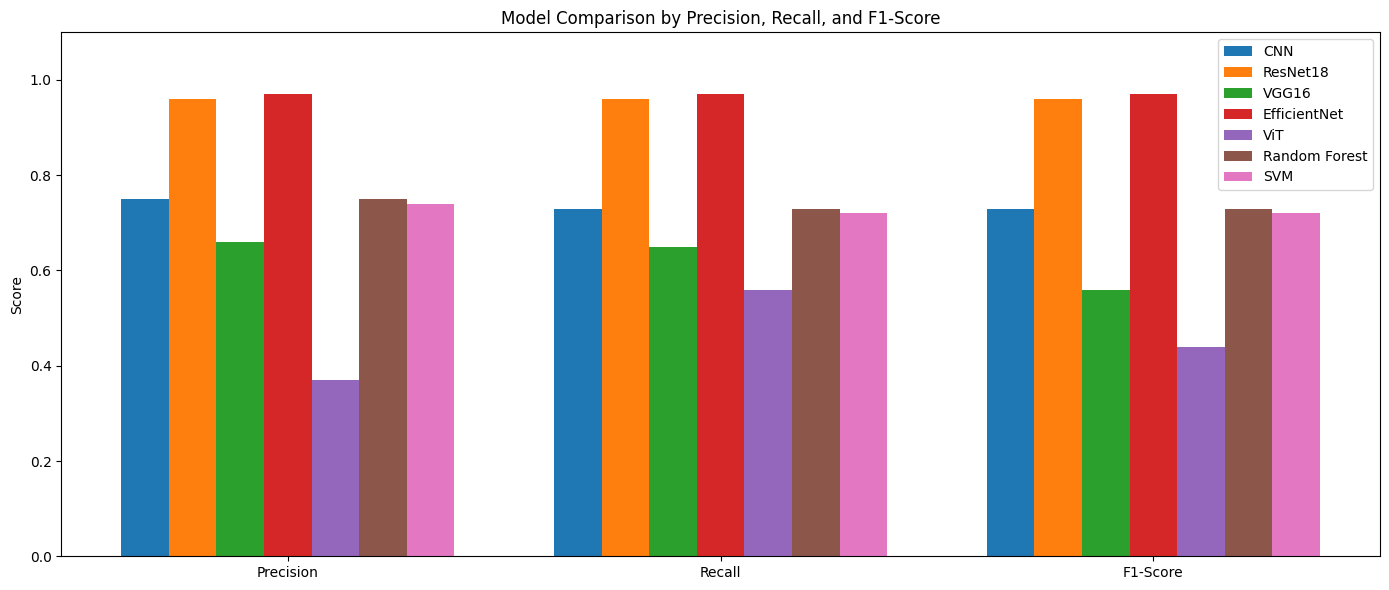

In [48]:
cnn_metrics = [0.75, 0.73, 0.73]
resnet_metrics = [0.96, 0.96, 0.96]
vgg16_metrics = [0.66, 0.65, 0.56]
effnet_metrics = [0.97, 0.97, 0.97]
vit_metrics = [0.37, 0.56, 0.44]
rf_metrics = [0.75, 0.73, 0.73]
svm_metrics = [0.74, 0.72, 0.72]

model_metrics = [cnn_metrics, resnet_metrics, vgg16_metrics, effnet_metrics, vit_metrics, rf_metrics, svm_metrics]
metrics_labels = ['Precision', 'Recall', 'F1-Score']
model_labels = ["CNN", "ResNet18", "VGG16", "EfficientNet", "ViT", "Random Forest", "SVM"]

x = np.arange(len(metrics_labels))
width = 0.11

plt.figure(figsize=(14, 6))
for i, metrics in enumerate(model_metrics):
    plt.bar(x + i * width, metrics, width, label=model_labels[i])

plt.ylabel('Score')
plt.title('Model Comparison by Precision, Recall, and F1-Score')
plt.xticks(x + width * 3, metrics_labels)
plt.ylim(0, 1.1)
plt.legend()
plt.tight_layout()
plt.show()


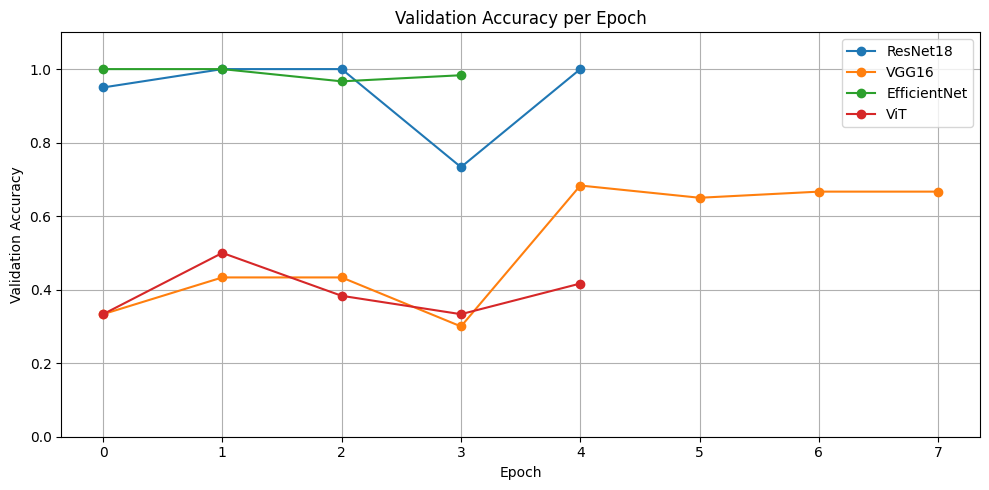

In [49]:
resnet_val = [0.95, 1.0, 1.0, 0.7333, 1.0]
vgg_val = [0.3333, 0.4333, 0.4333, 0.3, 0.6833, 0.65, 0.6667, 0.6667]
effnet_val = [1.0, 1.0, 0.9667, 0.9833]
vit_val = [0.3333, 0.5, 0.3833, 0.3333, 0.4167]

plt.figure(figsize=(10, 5))
plt.plot(resnet_val, label="ResNet18", marker='o')
plt.plot(vgg_val, label="VGG16", marker='o')
plt.plot(effnet_val, label="EfficientNet", marker='o')
plt.plot(vit_val, label="ViT", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy per Epoch")
plt.ylim(0, 1.1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [36]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.8 MB/s eta 0:00:00


updated

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import gradio as gr
import os



In [42]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 112 * 112, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class_names = ["Healthy", "Powdery", "Rust"]

inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])




In [43]:
def load_model(model_name):
    num_classes = 3
    if model_name == "CNN":
        model = CNNModel(num_classes)
        weights = "BestModel_CNN.pth"
    elif model_name == "ResNet18":
        model = models.resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        weights = "BestModel_ResNet18.pth"
    elif model_name == "VGG16":
        model = models.vgg16(pretrained=False)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        weights = "BestModel_VGG16.pth"
    elif model_name == "EfficientNet":
        model = models.efficientnet_b0(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        weights = "BestModel_EfficientNet.pth"
    elif model_name == "ViT":
        model = models.vit_b_16(pretrained=False)
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
        weights = "BestModel_ViT.pth"
    else:
        raise ValueError("Unsupported model")

    if not os.path.exists(weights):
        raise FileNotFoundError(f"Model weights not found: {weights}")

    model.load_state_dict(torch.load(weights, map_location="cpu"))
    model.eval()
    return model

def predict(image, model_choice):
    try:
        model = load_model(model_choice)
        img = inference_transform(image).unsqueeze(0)
        with torch.no_grad():
            outputs = model(img)
            probs = F.softmax(outputs[0], dim=0)
        return {class_names[i]: float(probs[i]) for i in range(len(class_names))}
    except Exception as e:
        return f"Error: {str(e)}"



In [44]:
interface = gr.Interface(
    fn=predict,
    inputs=[
        gr.Image(type="pil", label="Upload Leaf Image"),
        gr.Dropdown(["CNN", "ResNet18", "VGG16", "EfficientNet", "ViT"], label="Choose Model")
    ],
    outputs=gr.Label(num_top_classes=3),
    title=" Plant Disease Classifier",
    description="Upload a leaf image and choose a model to classify it as Healthy, Powdery, or Rust."
)

interface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2e6e0e695c4a73a4e5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
